In [3]:
# Make module from local packages importable
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [4]:
import tensorflow as tf
import yaml
import numpy as np
import matplotlib.pyplot as plt

from db_utils.db_connection import SumatraDB

## Load model

In [5]:
DATA_PATH="../data"
RECORD_LABEL="20180606-104310"
RECORD_PATH=os.path.join(DATA_PATH, RECORD_LABEL)


# Query config from database
db = SumatraDB(db="../.smt/records")
COLUMNS = ["label", "reason", "timestamp", "tags", "parameters_id", "version"]
record = db.get_filtered_by_label(COLUMNS, RECORD_LABEL)[0]
config = db.get_params_dic(record.params_id)

# Create folder for generated plots
if not os.path.exists("generated_plots"):
    os.mkdir("generated_plots")

config

{'class': 'src.test_retest.mri.unsupervised_features.PCAAutoEncoderTuples',
 'params': {'config': {'keep_checkpoint_max': 1,
   'log_step_count_steps': 100,
   'save_checkpoints_steps': 200,
   'save_summary_steps': 1,
   'tf_random_seed': 42},
  'data_params': {'dump_out_dir': 'produced_data', 'not_needed': 'not'},
  'hooks': {'confusion_matrix': True, 'icc_c1': True},
  'input_fn_config': {'batch_size': 4, 'num_epochs': 5, 'shuffle': None},
  'params': {'hidden_dim': 128,
   'hidden_lambda': 0,
   'hidden_regularizer': 'js_divergence',
   'input_dim': 902629,
   'lambda_w': 0,
   'learning_rate': 0.001,
   'n_classes': 10,
   'weight_regularizer': 'l2'},
  'streamer': {'class': 'src.data.streaming.mri_streaming.MRISamePatientSameAgePairStream',
   'params': {'stream_config': {'balanced_labels': ['healthy', 'health_ad'],
     'batch_size': 16,
     'data_sources': [{'glob_pattern': '/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/*_*.nii.gz',
       'id_from_filename': {'regex_id_gr

In [6]:
import importlib
# Load python class to construct object
def import_class(full_path):
    module_string = ".".join(full_path.split(".")[:-1])
    module = importlib.import_module(module_string)
    class_ = getattr(module, full_path.split(".")[-1])
    return class_
    
class_ = import_class(config["class"])
# Don't need streamer
s_class = config["params"]["streamer"]["class"]
s_class = import_class(s_class)
s_params = config["params"]["streamer"]["params"]
print(s_params)
csv_path = config["params"]["streamer"]["params"]["stream_config"]["meta_csv"]
config["params"]["streamer"]["params"]["stream_config"]["meta_csv"] = "../" + csv_path
streamer = s_class(**s_params)

config["params"]["streamer"] = None
obj = class_(**config["params"])

{'stream_config': {'balanced_labels': ['healthy', 'health_ad'], 'batch_size': 16, 'data_sources': [{'glob_pattern': '/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/*_*.nii.gz', 'id_from_filename': {'regex_id_group': 1, 'regexp': '.*/([AI0-9]+)_mni_aligned\\.nii\\.gz'}, 'name': 'ADNI_AIBL'}], 'downsample': {'enabled': False, 'shape': [28, 28]}, 'feature_collection': 'adni_aibl', 'meta_csv': 'data/raw/csv/adni_aibl__ad_hc.csv', 'meta_id_column': 'image_label', 'prefetch': 4, 'seed': 47, 'shuffle': True, 'train_ratio': 0.8}}


/local/home/mhoerold/entrack/src/data/streaming/base.py:478: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/103017_aug_mni_aligned.nii.gz
  .format(p))
/local/home/mhoerold/entrack/src/data/streaming/base.py:478: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/474676_aug_mni_aligned.nii.gz
  .format(p))
/local/home/mhoerold/entrack/src/data/streaming/base.py:478: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/57208_aug_mni_aligned.nii.gz
  .format(p))
/local/home/mhoerold/entrack/src/data/streaming/base.py:478: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/43116_aug_mni_aligned.nii.gz
  .format(p))
/local/home/mhoerold/entrack/src/data/streaming/base.py:478: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/367200_aug_mni_aligned.nii.gz
  .format(p))
/l

/local/home/mhoerold/entrack/src/data/streaming/base.py:478: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/323095_aug_mni_aligned.nii.gz
  .format(p))
/local/home/mhoerold/entrack/src/data/streaming/base.py:478: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/44192_aug_mni_aligned.nii.gz
  .format(p))
/local/home/mhoerold/entrack/src/data/streaming/base.py:478: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/131021_aug_mni_aligned.nii.gz
  .format(p))
/local/home/mhoerold/entrack/src/data/streaming/base.py:478: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/364207_aug_mni_aligned.nii.gz
  .format(p))
/local/home/mhoerold/entrack/src/data/streaming/base.py:478: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/484010_aug_mni_aligned.nii.gz
  .format(p))
/

ADNI_AIBL has 20092 files
8998 files found but not specified meta csv
Number of files: 11094
Number of files missing: 0
Achieved train ratio: 0.7996398018910401
>>>>>>>>> Sanity checks OK
>>>>>>>> Train stats
>>>>>>>>>>>>>>>>
>>>> Age stats, mean=75.47484984984985, std=6.6938722745886015
>>>> Age diffences stats, mean=0.0, std=0.0
>>>> healthy count: 6032
>>>> health_ad count: 4624
>>>>>>>>>>>>>>>>
>>>>>>>> Test stats
>>>>>>>>>>>>>>>>
>>>> Age stats, mean=75.75131086142322, std=7.304989583392815
>>>> Age diffences stats, mean=0.0, std=0.0
>>>> healthy count: 1520
>>>> health_ad count: 1150
>>>>>>>>>>>>>>>>


/local/home/mhoerold/entrack/src/data/streaming/mri_streaming.py:170: UserWarning: 11094 files not found
  warnings.warn("{} files not found".format(not_found))


In [7]:
# Construct estimator
est = tf.estimator.Estimator(
    model_fn=obj.model_fn,
    model_dir=RECORD_PATH,
    params=config["params"]["params"]
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '../data/20180606-104310', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f229737cac8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Analyze PCA transformation

In [22]:
W = est.get_variable_value('weights')

In [23]:
W.shape  # columns are principal components

(902629, 128)

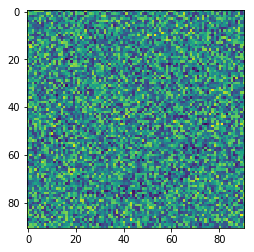

In [24]:
component = 3
image_shape = (91, 109, 91)
principal_vec = W[:, component]
vec_as_image = np.reshape(principal_vec, image_shape)
plt.imshow(vec_as_image[:, 50, :])

#### Reconstruct an image

In [17]:
image_label = "8225"
embedding_path = os.path.join("..", "produced_data", RECORD_LABEL, "test_4", image_label + "_mni_aligned.npy")
embedding = np.load(embedding_path)

In [18]:
reconstruction = np.matmul(np.reshape(embedding, (1, -1)), W.T)

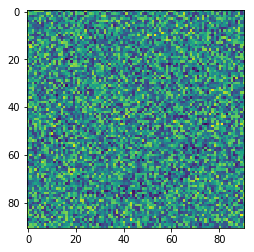

In [19]:
rec_image = np.reshape(reconstruction, image_shape)
plt.imshow(vec_as_image[:, 50, :])

In [20]:
# original image
import nibabel as nib

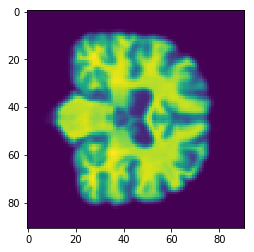

In [21]:
path = "/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/" + image_label + "_mni_aligned.nii.gz"
orig_im = nib.load(path).get_data()
orig_im = np.reshape(orig_im, image_shape)
plt.imshow(orig_im[:, 50, :])

In [ ]:
np.linalg.norm(orig_im - rec_image)

### Compute test_loss

In [ ]:
test_folder = os.path.join("..", "produced_data", RECORD_LABEL, "test_4")

In [ ]:
files = os.listdir(test_folder)

In [ ]:
files[:5]

In [ ]:
c = 0
loss = 0
maxi = 100
for test_file in files:
    c += 1
    if c > maxi:
        break
    # compute reconstruction
    image_label = test_file.split("_")[0]
    embedding_path = os.path.join(test_folder, image_label + "_mni_aligned.npy")
    embedding = np.load(embedding_path)
    reconstruction = np.matmul(np.reshape(embedding, (1, -1)), W.T)
    rec_image = np.reshape(reconstruction, image_shape)
    # load original
    path = "/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/" + image_label + "_mni_aligned.nii.gz"
    orig_im = nib.load(path).get_data()
    orig_im = np.reshape(orig_im, image_shape)
    
    loss += np.sum((rec_image - orig_im) ** 2) / maxi
    
print(loss)

In [ ]:
## Use tf to compute reconstruction

In [10]:
preds = est.predict(streamer.get_input_fn(False))

In [11]:
for pred in preds:
    print(pred)
    break

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../data/20180606-104310/model.ckpt-1665
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'hidden_rep': array([  7235.719  ,   8981.643  ,   9208.186  ,  -7684.987  ,
         8307.701  , -15326.466  ,  12793.804  ,   -831.6897 ,
        -2569.522  ,  -6759.68   ,   9573.876  ,  -4721.689  ,
        -4143.363  ,  -6739.409  ,  12283.202  ,   7861.9204 ,
        -1286.1477 ,  -6916.3936 ,   6444.6675 ,  -8616.901  ,
        -4005.9893 ,   5740.5747 ,   7471.535  ,  -9661.03   ,
         1047.6666 ,   4117.037  ,   6988.017  ,  11111.889  ,
        11403.411  ,  -7668.2046 ,  -1850.7567 ,  -1814.5404 ,
        -1452.6299 , -10999.16   ,  10918.338  , -11755.385  ,
         5031.949  ,  -5211.2686 ,   1839.6328 , -12391.515  ,
       

In [12]:
pred

{'hidden_rep': array([  7235.719  ,   8981.643  ,   9208.186  ,  -7684.987  ,
          8307.701  , -15326.466  ,  12793.804  ,   -831.6897 ,
         -2569.522  ,  -6759.68   ,   9573.876  ,  -4721.689  ,
         -4143.363  ,  -6739.409  ,  12283.202  ,   7861.9204 ,
         -1286.1477 ,  -6916.3936 ,   6444.6675 ,  -8616.901  ,
         -4005.9893 ,   5740.5747 ,   7471.535  ,  -9661.03   ,
          1047.6666 ,   4117.037  ,   6988.017  ,  11111.889  ,
         11403.411  ,  -7668.2046 ,  -1850.7567 ,  -1814.5404 ,
         -1452.6299 , -10999.16   ,  10918.338  , -11755.385  ,
          5031.949  ,  -5211.2686 ,   1839.6328 , -12391.515  ,
         -4798.0894 , -13257.772  ,   5327.5454 ,   -938.0796 ,
         -2211.4446 ,  -5120.1304 ,  -6248.6396 ,   5267.664  ,
        -13217.108  ,   6966.9834 ,  -7758.4673 ,   -863.82904,
         -9455.467  ,  -3377.194  ,  11611.523  ,  -7898.9146 ,
         -9059.623  ,   -149.92874,  14026.076  ,   7579.5483 ,
          7390.5244 ,   27

In [13]:
reco = pred["reconstruction"]

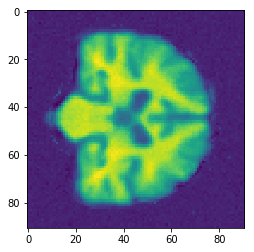

In [16]:
reco = np.reshape(reco, image_shape)
plt.imshow(reco[:, 50, :])